## Step 1. Choose open-source LLM

From this source https://www.mongodb.com/developer/products/atlas/choose-embedding-model-rag/ I learned about MTEB leaderboard. There I searched for model with word "small" in it, but they were not small enough so I simply sorted them by model size and took one with reliable naming

In [ ]:
from transformers import AutoModel
model_name = 'Mihaiii/gte-micro-v3'
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/597 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

## Step 2. Download dataset “Netflix Reviews”, sample 2000 random objects. Uniformly distribute data alongside "score" column. Focuse on columns “content” and “score”.


I uploaded dataset and checked first lines for general comfort. Next i printed distribution of values in score column, as among this column I will need to distribute data.

In [ ]:
import pandas as pd

dataset = pd.read_csv('netflix_reviews.csv')
print(dataset.head())
print(dataset.score.value_counts(dropna=False))

                               reviewId             userName  \
0  1bd2041f-0a90-4089-a9ac-8d3c593e65e6        Brand SA Chea   
1  fff52ee7-b0f8-4a5b-a125-fd2c65a0b99d            tony lags   
2  60e7140e-cec4-4c21-aeba-0e16c4e8879c  Otte “HiROMi” Hilmi   
3  d851f774-8a57-4eee-b26f-7432ab7e9cfd                Meg M   
4  4d8cdc86-7698-45df-95fb-4a5b21981c1d         a random guy   

                                             content  score  thumbsUpCount  \
0                                So great & reliable      5              0   
1                                Netflix Jan 14 2015      5              0   
2  The subtitles ALWAYS didn't show up if I don't...      2              0   
3                   its netflix nothing rong with it      5              0   
4                                    I love trattors      4              0   

     reviewCreatedVersion                   at              appVersion  
0                     NaN  2024-06-17 21:28:48                     NaN  


I grouped dataset by score and uniformly sampled random 400 lines for each group. Next I only left 2 important columns and checked head & distribution

In [ ]:
unique_values = dataset['score'].nunique()
sample_size = 2000 // unique_values
samples = dataset.groupby('score').sample(n=sample_size, random_state=123)
samples = samples[['score', 'content']]

print(samples.head())
print(samples['score'].value_counts())


        score                                            content
46031       1  Watching Netflix is very much like walking bar...
61899       1  Shady. Coincidentally, the rollout of the new ...
59458       1  After the update, everyone I try to watch some...
79346       1  my netflix is not even working from past many ...
108602      1  Fix the black screen can't watch on my mobile ...
score
1    400
2    400
3    400
4    400
5    400
Name: count, dtype: int64


## Step 3. Use LLM to create embeddings

I am using the uploaded LLM to generate emeddings. The example usage from the model card on hugging face looked overcomplicated (and in practice actually the time and system resources showed me bad results), so I used simplified option.

In [ ]:
import pandas as pd
from transformers import pipeline

embedding_pipeline = pipeline('feature-extraction', model=model_name)
samples['embedding'] = samples['content'].apply(lambda x: embedding_pipeline(x)[0])

print(samples.head())


## Step 4.  Perform clusterization with different types of distance metrics

I separately stated formulas for for each distance. Inside knn function I iterate in the loops and calculate the closest distance, save it and distribute to clusters. I tried random assignment of first cluster, but it was spoiling the distribution so I consulted with net and came up with kmeans function.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def manhattan_distance(point1, point2):
    return np.sum(np.abs(point1 - point2))

def minkowski_distance(point1, point2, p):
    return np.sum(np.abs(point1 - point2) ** p) ** (1/p)

def kmeans_plusplus_initialization(data, num_initial_clusters):
    kmeans = KMeans(n_clusters=num_initial_clusters, init='k-means++', n_init=1, random_state=42)
    kmeans.fit(data)
    return kmeans.labels_

def knn_clustering(data, k=3, metric='euclidean', p=3, num_initial_clusters=5, max_iters=100):
    n_samples = data.shape[0]
    clusters = clusters = kmeans_plusplus_initialization(data, num_initial_clusters)  # Initial random cluster assignment
    n_samples = data.shape[0]
    distances = np.zeros((n_samples, n_samples))

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if metric == 'euclidean':
                distance = euclidean_distance(data[i], data[j])
            elif metric == 'manhattan':
                distance = manhattan_distance(data[i], data[j])
            elif metric == 'minkowski':
                distance = minkowski_distance(data[i], data[j], p)
            distances[i, j] = distances[j, i] = distance

    for _ in range(max_iters):
        new_clusters = clusters.copy()
        for i in range(n_samples):
            neighbors = np.argsort(distances[i])[:k]
            neighbor_clusters = clusters[neighbors]
            most_common_cluster = np.argmax(np.bincount(neighbor_clusters))
            new_clusters[i] = most_common_cluster

        if np.all(clusters == new_clusters):
            break
        clusters = new_clusters

    final_neighbors = [np.argsort(distances[i])[1:k+1] for i in range(n_samples)]

    return clusters, final_neighbors


df = pd.DataFrame(samples)
embeddings = np.array([np.array(embed[0]) for embed in df['embedding']])


pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

k = 3
clusters_euclidean, neighbors_euclidean = knn_clustering(embeddings, k, metric='euclidean')

clusters_manhattan, neighbors_manhattan = knn_clustering(embeddings, k, metric='manhattan')

p = 3
clusters_minkowski, neighbors_minkowski = knn_clustering(embeddings, k, metric='minkowski', p=p)



## Step 5. Visualize results and reflect.

The points distribution is presented on the graphs. Actually, the closest points by algorithm are not the closest for our eyes, but I tend to explain it as the representation in 2D affects the position and in initial dimensions points are in fact close. Euclidian and Minkovski found same points, Manhattan had 1 different. Was tested on point with index 0.

Cluster labels and their counts:
Cluster 0: 378 points
Cluster 1: 329 points
Cluster 2: 476 points
Cluster 3: 462 points
Cluster 4: 355 points


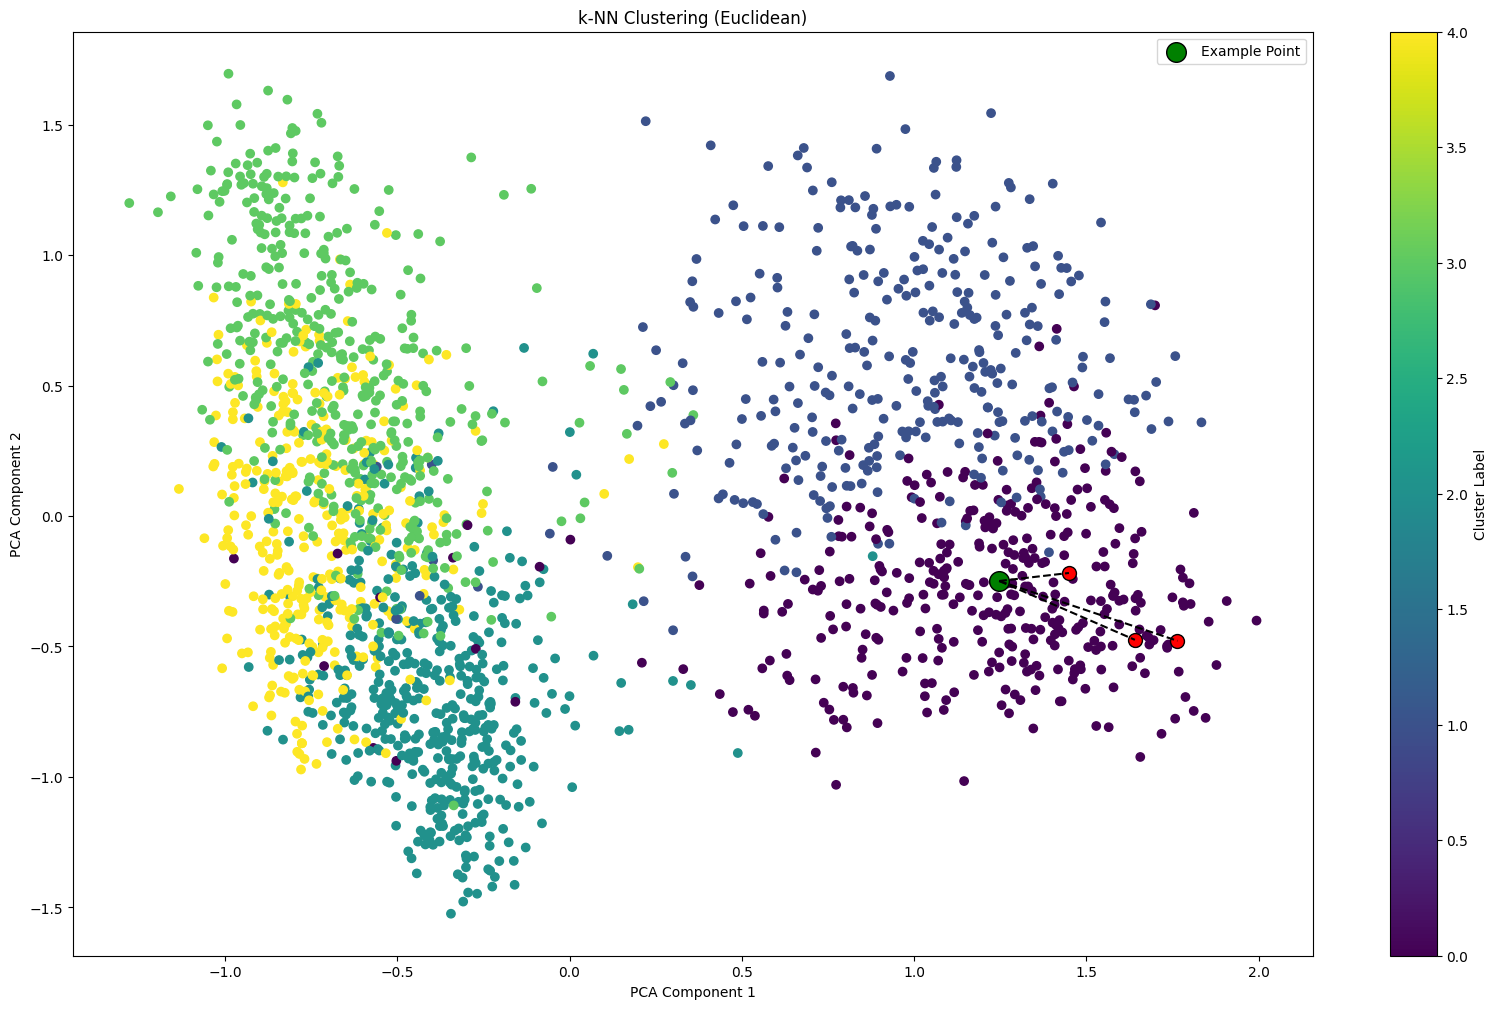

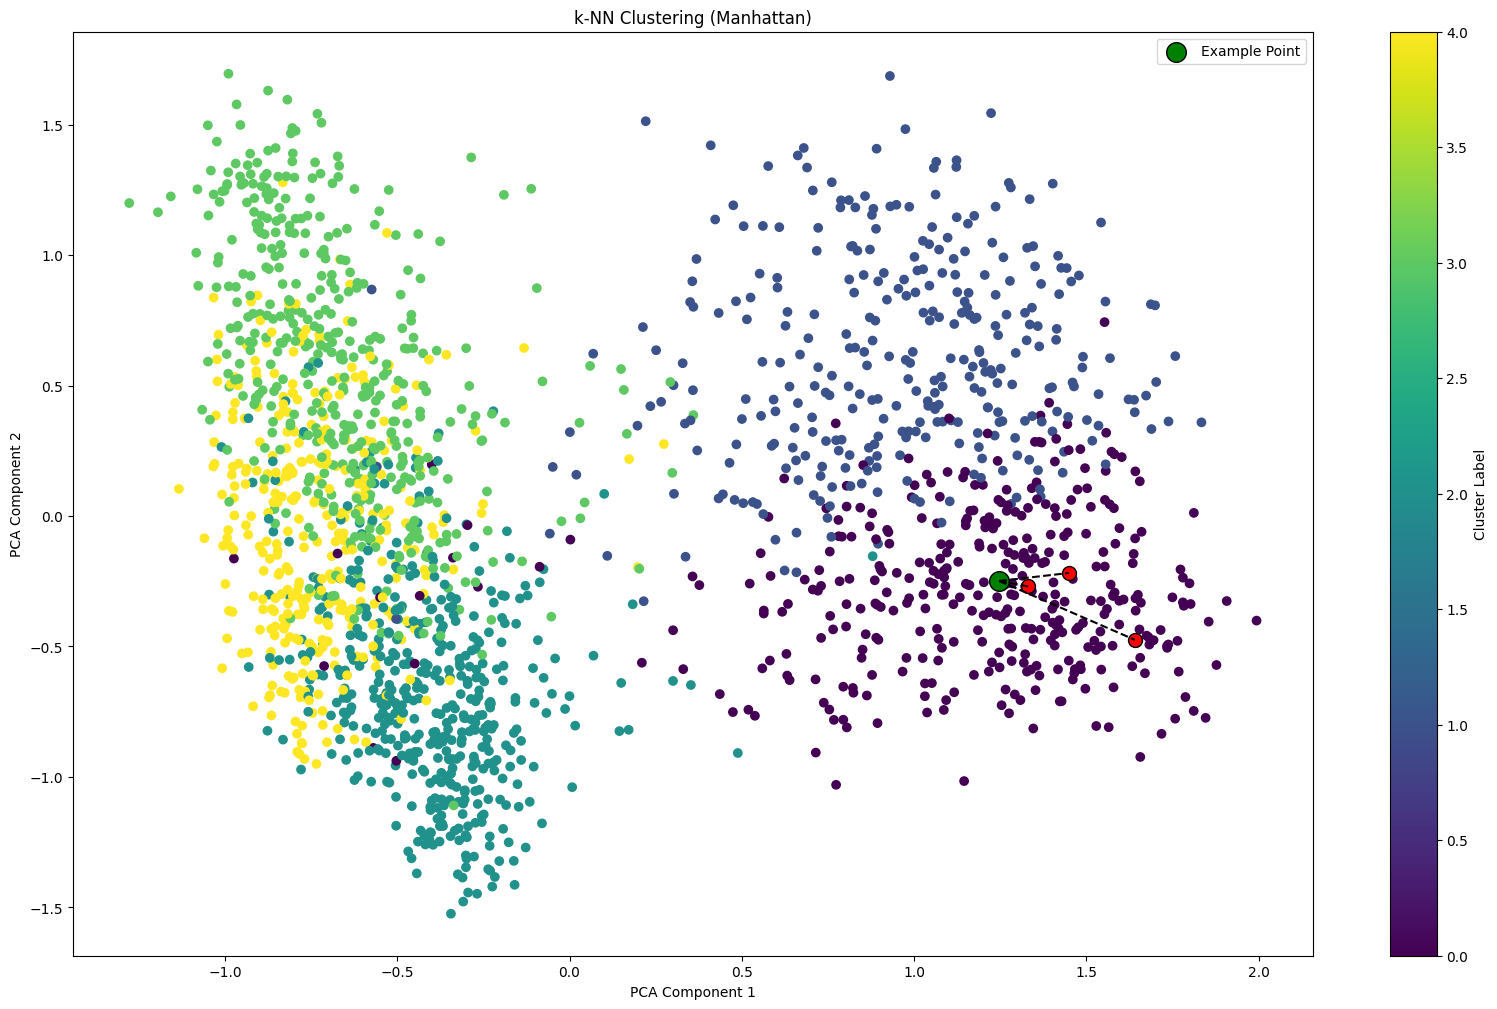

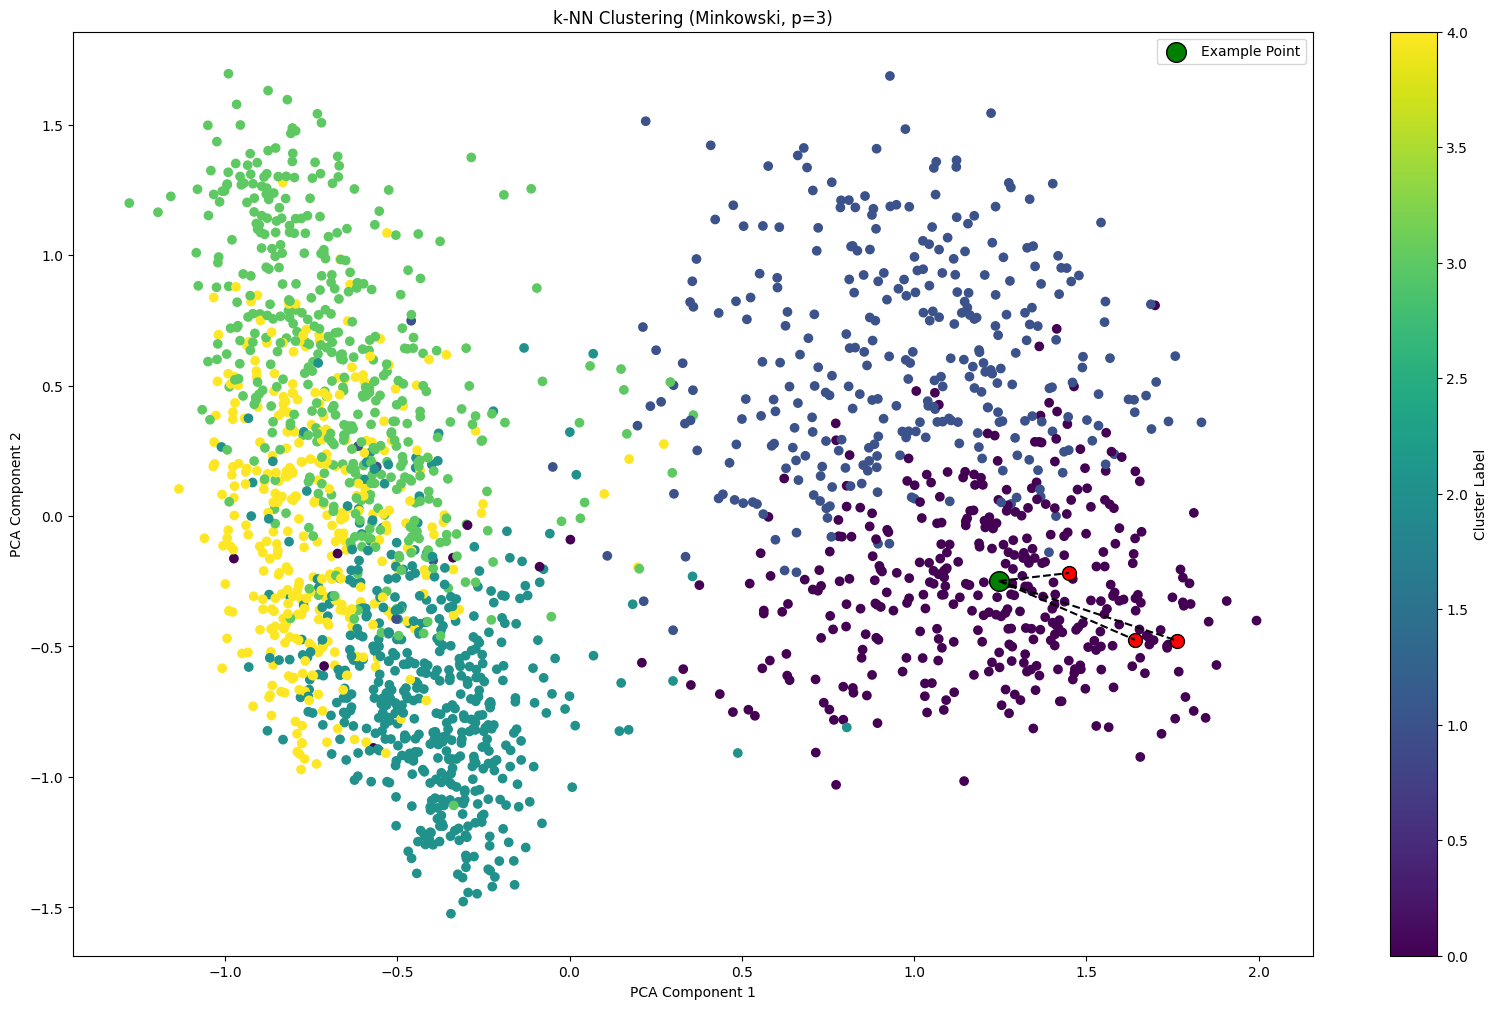

In [ ]:
import matplotlib.pyplot as plt
unique_clusters, counts = np.unique(clusters_euclidean, return_counts=True)
print("Cluster labels and their counts:")
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} points")

def visualize_knn(reduced_data, clusters, neighbors, title, example_idx=0):
    plt.figure(figsize=(20, 12))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.colorbar(scatter, label='Cluster Label')
    example_point = reduced_data[example_idx]
    nearest_neighbors = neighbors[example_idx]

    plt.scatter(example_point[0], example_point[1], color='green', edgecolor='black', s=200, label='Example Point')

    for neighbor in nearest_neighbors:
        neighbor_point = reduced_data[neighbor]
        plt.plot([example_point[0], neighbor_point[0]], [example_point[1], neighbor_point[1]], 'k--')
        plt.scatter(neighbor_point[0], neighbor_point[1], color='red', edgecolor='black', s=100)

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

visualize_knn(embeddings_2d, clusters_euclidean, neighbors_euclidean, 'k-NN Clustering (Euclidean)', example_idx=0)
visualize_knn(embeddings_2d, clusters_manhattan, neighbors_manhattan,  'k-NN Clustering (Manhattan)', example_idx=0)
visualize_knn(embeddings_2d, clusters_minkowski, neighbors_minkowski, f'k-NN Clustering (Minkowski, p={p})', example_idx=0)

I also displayed some random points and their neighbors with tests, just to see if the context is close. Well, they present same cluster and mostly express same idea of good/bad review, also have shared words, ideas. But sometimes if people use sarcasm or words like amazing, brilliant etc to descrive sth bad, there can happen the misunderstanding (observed it with smaller sample size, 500 vs 2000, might as well appear here)

In [ ]:
def print_neighbors(metric, clusters, neighbors, samples, example_index=0):
    print(f"Neighbors using {metric} distance:")
    point_id = samples.index[example_index]
    print(f"\nPoint {point_id} (Cluster {clusters[example_index]}):")
    try:
        print(f"  Text: {samples.loc[point_id, 'content']}")
        for neighbor in neighbors[example_index]:
            neighbor_id = samples.index[neighbor]
            print(f"  Neighbor {neighbor_id} (Cluster {clusters[neighbor]}):")
            print(f"    Text: {samples.loc[neighbor_id, 'content']}")
    except KeyError as e:
        print(f"KeyError: {e}")


print_neighbors('euclidean', clusters_euclidean, neighbors_euclidean, samples, example_index=0)
print('\n')
print_neighbors('manhattan', clusters_manhattan, neighbors_manhattan, samples, example_index=700)
print('\n')
print_neighbors('minkowski', clusters_minkowski, neighbors_minkowski, samples, example_index=200)


Neighbors using euclidean distance:

Point 46031 (Cluster 0):
  Text: Watching Netflix is very much like walking barefoot through mud. You never know what you are going to run into. You just hope you can get through uninjured.
  Neighbor 105208 (Cluster 0):
    Text: I love Netflix. I just run out of things to watch!
  Neighbor 87335 (Cluster 0):
    Text: Not sure, issues with Netflix, having hard time getting to watch anything
  Neighbor 1459 (Cluster 0):
    Text: I love Netflix...


Neighbors using manhattan distance:

Point 34616 (Cluster 1):
  Text: It's hard to enjoy Netflix when the app's streaming quality has been bad since this latest update. Blurry or pixelated with both mobile data and wi-fi.
  Neighbor 10501 (Cluster 1):
    Text: Netflix is by far the buggiest app i have installed on my phone (P20 Pro & OP3T). Videos cant be played as long as all other apps are closed and force stopped (RAM issue i guess and that since 4 months). Switching to another apps while watching l